In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import geopandas as gpd
import pickle
from shapely.geometry import Point
import os
import re
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import pyreadstat


In [298]:
# !pip install pyreadstat

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error, r2_score

## Carga, análisis y limpieza de datos desde bases SPSS de PISA

In [2]:
stu, meta_stu = pyreadstat.read_sav("CY6_MS_CM2_STU_QQQ.sav") #Levanta tabla de estudiantes

ReadstatError: Unable to open file

In [ ]:
meta_stu

In [283]:
stu = pickle.load(open('stu.p',"rb"))
stu.head()

,index,CNTRYID,CNT,CNTSCHID,CNTSTUID,CYC,NatCen,Region,STRATUM,SUBNATIO,...,SENWT,VER_DAT,MATH,READ,SCI,Max_Score,Min_Score,score_total,score_range,score_range2
0,5215,32.0,ARG,3200001.0,3206226.0,06MS,003200,3200.0,ARG0003,0320000,...,0.74958,15NOV16:10:17:00,306.8010,259.1677,299.7150,MATH,READ,289.0,1,1
1,5216,32.0,ARG,3200001.0,3200366.0,06MS,003200,3200.0,ARG0003,0320000,...,0.74958,15NOV16:10:17:00,365.8349,368.9647,382.1997,SCI,MATH,372.0,1,1
2,5217,32.0,ARG,3200001.0,3200847.0,06MS,003200,3200.0,ARG0003,0320000,...,0.85682,15NOV16:10:17:00,277.4815,204.9901,209.5475,MATH,READ,231.0,1,1
3,5218,32.0,ARG,3200001.0,3206105.0,06MS,003200,3200.0,ARG0003,0320000,...,0.85682,15NOV16:10:17:00,366.4782,366.7180,385.4713,SCI,MATH,373.0,1,1
4,5219,32.0,ARG,3200001.0,3202446.0,06MS,003200,3200.0,ARG0003,0320000,...,0.85682,15NOV16:10:17:00,375.1508,266.5500,376.9701,SCI,READ,340.0,1,1


In [284]:
print("Estudiantes", stu.shape)

Estudiantes (23051, 930)


In [285]:
stu.CNT.value_counts()

MYS    8861
KAZ    7841
ARG    6349
Name: CNT, dtype: int64

In [286]:
# Creo el promedio para los valores posibles de notas en matemática, lectura y ciencia

In [287]:
stu["MATH"] = stu[["PV1MATH", "PV2MATH", "PV3MATH", "PV4MATH", "PV5MATH", "PV6MATH", "PV7MATH", "PV8MATH", "PV9MATH", "PV10MATH"]].mean(axis=1)
stu["READ"] = stu[["PV1READ", "PV2READ", "PV3READ", "PV4READ", "PV5READ", "PV6READ", "PV7READ", "PV8READ", "PV9READ", "PV10READ"]].mean(axis=1)
stu["SCI"] = stu[["PV1SCIE", "PV2SCIE", "PV3SCIE", "PV4SCIE", "PV5SCIE", "PV6SCIE", "PV7SCIE", "PV8SCIE", "PV9SCIE", "PV10SCIE"]].mean(axis=1)
# me quedo con los registros donde hay valores para las 3 asignaturas
stu = stu.loc[stu[["MATH", "READ", "SCI"]].isnull().sum(axis=1) != 3, :]
stu.loc[:, ["MATH", "READ", "SCI"]].head()

stu.loc[:, "Max_Score"] = stu.loc[:, ["MATH", "READ", "SCI"]].idxmax(axis=1) 

stu.loc[:, "Min_Score"] = stu.loc[:, ["MATH", "READ", "SCI"]].idxmin(axis=1) 

stu.loc[:,["MATH", "READ", "SCI", "Max_Score", "Min_Score"]].sample(5)


,MATH,READ,SCI,Max_Score,Min_Score
21831,515.6234,470.2467,485.8994,MATH,READ
16290,500.6489,523.4650,523.5731,SCI,MATH
21683,452.5819,443.5931,463.9443,SCI,READ
8314,480.4372,427.3898,521.8006,SCI,READ
7023,350.9218,282.9915,336.5308,MATH,READ


In [288]:
stu2 = pickle.load(open('stu_sample.p',"rb"))
stu2.head()

,CNTRYID,CNT,CNTSCHID,CNTSTUID,CYC,NatCen,Region,STRATUM,SUBNATIO,OECD,...,PV3SSES,PV4SSES,PV5SSES,PV6SSES,PV7SSES,PV8SSES,PV9SSES,PV10SSES,SENWT,VER_DAT
41922,76.0,BRA,7600001.0,7628061.0,06MS,007600,7600.0,BRA2549,0760000,0.0,...,292.441,265.223,349.694,359.034,333.992,323.978,355.030,290.974,0.50861,14NOV16:20:25:00
41923,76.0,BRA,7600001.0,7611939.0,06MS,007600,7600.0,BRA2549,0760000,0.0,...,263.857,333.110,289.815,275.886,308.443,334.062,347.188,356.220,0.50861,14NOV16:20:25:00
41924,76.0,BRA,7600001.0,7600555.0,06MS,007600,7600.0,BRA2549,0760000,0.0,...,271.911,302.190,230.035,224.453,368.723,241.524,330.580,240.854,0.43085,14NOV16:20:25:00
41925,76.0,BRA,7600001.0,7629227.0,06MS,007600,7600.0,BRA2549,0760000,0.0,...,324.209,308.340,305.776,321.851,259.394,320.636,349.514,306.663,0.43085,14NOV16:20:25:00
41926,76.0,BRA,7600001.0,7621770.0,06MS,007600,7600.0,BRA2549,0760000,0.0,...,328.754,233.642,375.885,254.953,396.913,425.482,356.967,308.303,0.43085,14NOV16:20:25:00


In [289]:
stu2["MATH"] = stu2[["PV1MATH", "PV2MATH", "PV3MATH", "PV4MATH", "PV5MATH", "PV6MATH", "PV7MATH", "PV8MATH", "PV9MATH", "PV10MATH"]].mean(axis=1)
stu2["READ"] = stu2[["PV1READ", "PV2READ", "PV3READ", "PV4READ", "PV5READ", "PV6READ", "PV7READ", "PV8READ", "PV9READ", "PV10READ"]].mean(axis=1)
stu2["SCI"] = stu2[["PV1SCIE", "PV2SCIE", "PV3SCIE", "PV4SCIE", "PV5SCIE", "PV6SCIE", "PV7SCIE", "PV8SCIE", "PV9SCIE", "PV10SCIE"]].mean(axis=1)
# me quedo con los registros donde hay valores para las 3 asignaturas
stu2 = stu2.loc[stu2[["MATH", "READ", "SCI"]].isnull().sum(axis=1) != 3, :]
stu2.loc[:, ["MATH", "READ", "SCI"]].head()

stu2.loc[:, "Max_Score"] = stu2.loc[:, ["MATH", "READ", "SCI"]].idxmax(axis=1) 

stu2.loc[:, "Min_Score"] = stu2.loc[:, ["MATH", "READ", "SCI"]].idxmin(axis=1) 

stu2.loc[:,["MATH", "READ", "SCI", "Max_Score", "Min_Score"]].sample(5)

,MATH,READ,SCI,Max_Score,Min_Score
463002,545.0995,532.7516,560.1616,SCI,READ
61924,364.0623,420.4865,422.4227,SCI,MATH
116825,475.5928,502.0062,534.4622,SCI,MATH
465454,477.0238,477.1562,499.7546,SCI,MATH
286730,395.0657,446.6246,415.9962,READ,MATH


In [290]:
stu = pd.concat([stu, stu2], ignore_index=True)

C:\Users\sanap\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [291]:
stu.shape

(98378, 930)

In [292]:
stu = stu[[
'CNT',   
 'DISCLISCI',
 'TEACHSUP',
 'IBTEACH',
 'TDTEACH',
 'ENVAWARE',
 'ENVOPT',
 'JOYSCIE',
 'INTBRSCI',
 'INSTSCIE',
 'SCIEEFF',
 'EPIST',
 'SCIEACT',
 'hisei',
 'OUTHOURS',
 'MMINS',
 'LMINS',
 'SMINS',
 'TMINS',
 'BELONG',
 'ANXTEST',
 'MOTIVAT',
 'COOPERATE',
 'CPSVALUE',
 'EMOSUPS',
 'PERFEED',
 'ADINST',
 'unfairteacher',
 'PARED',
 'CULTPOSS',
 'HEDRES',
 'HOMEPOS',
 'ICTRES',
 'WEALTH',
 'ESCS', 
 'Region',
 'IMMIG',
 'MISCED',
 'FISCED',
 'HISCED',
 'REPEAT',
 'DURECEC',
  'COBN_F',
  'COBN_M',
  'COBN_S',
'ST022Q01TA', 'MATH', 'READ', 'SCI', 'Max_Score', 'Min_Score', 'SENWT', 'W_FSTUWT']]

In [293]:
# Calculamos la variable a clasificar de los promedios de cada área, usando los criterios de PISA
stu["score_total"] = round(stu[["MATH", "READ", "SCI"]].mean(axis=1))
stu["score_range"] = 1
stu.loc[(stu.score_total >= 340)&(stu.score_total < 440), "score_range"]=1
stu.loc[(stu.score_total >= 440)&(stu.score_total < 540), "score_range"]=2
stu.loc[(stu.score_total >= 540)&(stu.score_total < 640), "score_range"]=3
stu.loc[stu.score_total >= 640, "score_range"]=4

stu["score_range2"] = 9999
stu.loc[(stu.score_range == 1),"score_range2"] = 0
stu.loc[(stu.score_range == 2)|(stu.score_range == 3)|(stu.score_range == 4),"score_range2"] = 1

print(stu.score_range.value_counts())
print(stu.score_range2.value_counts()) #Observamos si nuestras clases están bien balanceadas


1    46855
2    35936
3    14212
4     1375
Name: score_range, dtype: int64
1    51523
0    46855
Name: score_range2, dtype: int64


In [294]:
stu.shape

(98378, 56)

In [295]:
pickle.dump(stu,open('stu_all.p', "wb"))

In [296]:
stu.CNT.unique()

array(['ARG', 'KAZ', 'MYS', 'BRA', 'CAN', 'CHL', 'COL', 'MEX', 'USA'],
      dtype=object)

In [297]:
stu.score_range2.unique()

array([0, 1], dtype=int64)

# Levanto dataset de estudiantes

In [244]:
stu = pickle.load(open('stu_all.p',"rb"))


In [246]:
weight = stu.W_FSTUWT

In [247]:
X_numericas = stu[[
 'DISCLISCI',
 'TEACHSUP',
 'IBTEACH',
 'TDTEACH',
 'ENVAWARE',
 'ENVOPT',
 'JOYSCIE',
 'INTBRSCI',
 'INSTSCIE',
 'SCIEEFF',
 'EPIST',
 'SCIEACT',
 'hisei',
 'OUTHOURS',
 'MMINS',
 'LMINS',
 'SMINS',
 'TMINS',
 'BELONG',
 'ANXTEST',
 'MOTIVAT',
 'COOPERATE',
 'CPSVALUE',
 'EMOSUPS',
 'PERFEED',
 'ADINST',
 'unfairteacher',
 'PARED',
 'CULTPOSS',
 'HEDRES',
 'HOMEPOS',
 'ICTRES',
 'WEALTH',
 'ESCS',]]

X_numericas.sample(3)

,DISCLISCI,TEACHSUP,IBTEACH,TDTEACH,ENVAWARE,ENVOPT,JOYSCIE,INTBRSCI,INSTSCIE,SCIEEFF,...,PERFEED,ADINST,unfairteacher,PARED,CULTPOSS,HEDRES,HOMEPOS,ICTRES,WEALTH,ESCS
39576,-1.6054,1.4475,0.3996,2.0781,-3.3765,3.0127,0.0875,0.0764,NaN,NaN,...,1.3685,-0.3816,12.0,12.0,-0.6174,-0.1108,-0.9647,-0.8890,-0.9520,-1.0446
91726,0.3993,1.4475,3.1829,2.0781,0.8948,0.4639,0.5094,-0.1643,0.3708,0.7788,...,1.0606,2.0469,6.0,14.0,0.6062,1.1563,-0.5176,-0.5600,-1.0137,0.0454
28270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.0,9.0,0.3670,1.1563,-1.0044,-1.1173,-1.5572,-1.5076


## Creación de Dummies para X

In [248]:
X_dummies = stu[[
  'Region',
 'IMMIG',
 'MISCED',
 'FISCED',
 'HISCED',
 'REPEAT',
 'DURECEC',
  'COBN_F',
  'COBN_M',
  'COBN_S',
'ST022Q01TA',
]]

X_dummies.sample(3)

,Region,IMMIG,MISCED,FISCED,HISCED,REPEAT,DURECEC,COBN_F,COBN_M,COBN_S,ST022Q01TA
22793,45800.0,NaN,NaN,NaN,NaN,NaN,NaN,,,,NaN
864,3200.0,1.0,5.0,5.0,5.0,0.0,NaN,003200,003200,003200,1.0
4279,3200.0,1.0,4.0,4.0,4.0,1.0,NaN,003200,003200,003200,1.0


In [249]:
dummies_resul = []
for x in X_dummies.columns:
    
    dummies = pd.get_dummies(X_dummies[x], prefix=x+"_", drop_first=True)
    
    if len(dummies_resul)==0:
        dummies_resul = dummies.copy()
    else:
        dummies_resul = pd.concat([dummies_resul, dummies], axis=1)
    

In [250]:
X = pd.concat([X_numericas, dummies_resul], axis=1)

In [251]:
X.sample(3)

,DISCLISCI,TEACHSUP,IBTEACH,TDTEACH,ENVAWARE,ENVOPT,JOYSCIE,INTBRSCI,INSTSCIE,SCIEEFF,...,COBN_S__181004,COBN_S__903200,COBN_S__907600,COBN_S__915200,COBN_S__917000,COBN_S__939800,COBN_S__945800,COBN_S__948400,COBN_S__984000,ST022Q01TA__2.0
55044,-0.0405,-0.1164,-0.0890,-0.6102,-0.0081,-1.0294,-0.2145,-1.4829,-0.5375,0.0900,...,0,0,0,0,0,0,0,0,0,0
58204,-0.3164,0.3574,0.9452,-0.6102,0.5925,-1.0294,-1.4311,-0.7446,-1.9301,-0.5508,...,0,0,0,0,0,0,0,0,0,1
97158,0.0039,-0.1164,0.4311,0.4505,-0.1824,3.0127,0.5094,0.3721,0.3708,0.5037,...,0,0,0,0,0,0,0,0,0,0


## Variable objetivo

1    46855
2    35936
3    14212
4     1375
Name: score_range, dtype: int64
2    51523
1    46855
Name: score_range2, dtype: int64


In [175]:
y = stu.score_range2 

In [255]:
print('X     ', X.shape)
print('y     ', y.shape)
print('weight', weight.shape)

X      (98378, 149)
y      (98378,)
weight (98378,)


## TREE MODEL

In [144]:
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

In [145]:
# partimos en entrenamiento-prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [41]:
# Ajustar un árbol de clasificación con max_depth=3
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [50]:
y_pred = treeclf.predict(X_test) #Está usando la media y el desvió estándar del train, y no del test, así no hay data leakage
confusion_matrix(y_test, y_pred)

array([[ 197,  306],
       [  94, 1266]], dtype=int64)

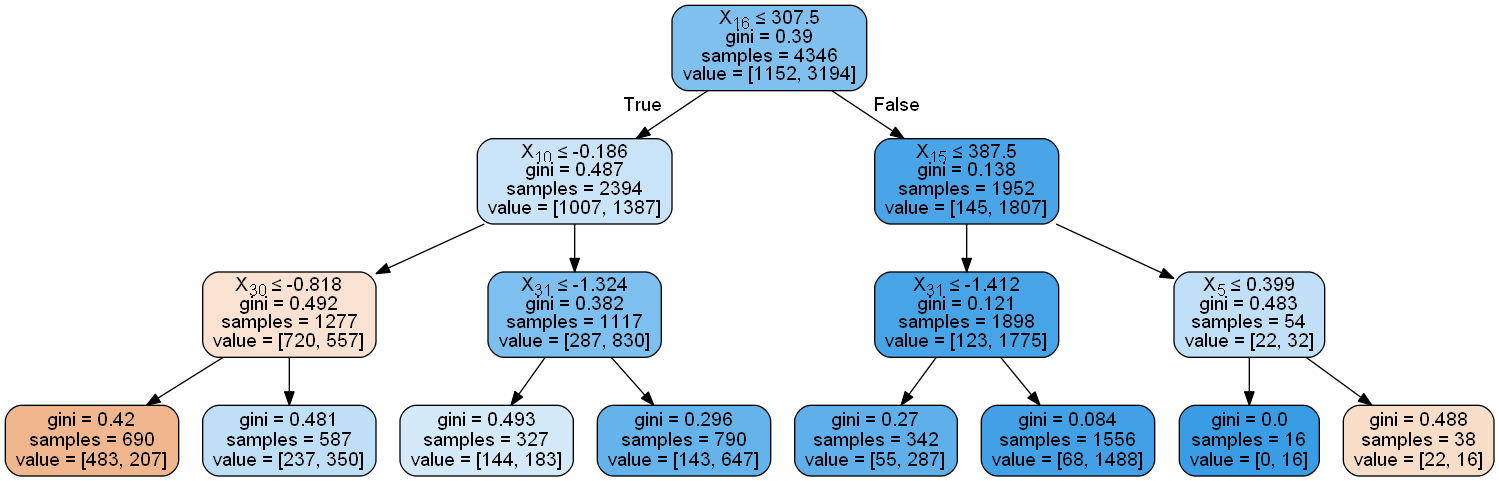

In [46]:
# Visualizar el árbol usando graphviz
dot_data = export_graphviz(treeclf, out_file=None,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

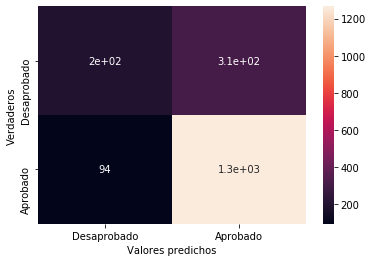

In [54]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels=["Desaprobado", "Aprobado"], yticklabels=["Desaprobado", "Aprobado"])
plt.ylabel('Verdaderos')
plt.xlabel('Valores predichos');

In [51]:
print('Métricas de predicción para test Tree')
print("Accuracy:",'{:.2%}'.format(accuracy_score(y_test, y_pred)))
print("Recall:",'{:.2%}'.format(recall_score(y_test, y_pred)))
print("Precisión:",'{:.2%}'.format(precision_score(y_test, y_pred)))
print("F1Score:",'{:.2%}'.format(f1_score(y_test,y_pred)))

Métricas de predicción para test Tree
Accuracy: 78.53%
Recall: 39.17%
Precisión: 67.70%
F1Score: 49.62%


In [53]:
pd.DataFrame({'atributo':X.columns, 'importancia':treeclf.feature_importances_}).sort_values('importancia', ascending = False)

,atributo,importancia
16,SMINS,0.532399
10,EPIST,0.231608
30,HOMEPOS,0.114896
31,ICTRES,0.080082
15,LMINS,0.025438
5,ENVOPT,0.015577
76,COBN_F__945800,0.000000
75,COBN_F__939800,0.000000
74,COBN_F__903200,0.000000
73,COBN_F__181004,0.000000


## Random Forest

In [257]:
from sklearn.ensemble import RandomForestClassifier

In [258]:
X.dropna(axis=0, inplace=True) #sacamos filas que tienen NaN
X.shape

(21682, 149)

In [197]:
listado=X.index.tolist()
y=y[listado] #sacamos las mismas filas en y 
y.shape

weight_x = weight[listado]

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [201]:
listado_train=X_train.index.tolist()
weight_x_train=weight_x[listado_train] #sacamos las mismas filas en y 
weight_x_train.shape

(15177,)

In [203]:
listado_test=X_test.index.tolist()
weight_x_test=weight_x[listado_test] #sacamos las mismas filas en y 
weight_x_test.shape

(6505,)

In [202]:
# Ajustar un Random Forest de clasificación con max_depth=3
rforestclf = RandomForestClassifier(max_depth=None, random_state=1, n_jobs=-1)
rforestclf.fit(X_train, y_train, sample_weight=weight_x_train)

C:\Users\sanap\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [204]:
y_pred = rforestclf.predict(X_test) #Está usando la media y el desvió estándar del train, y no del test, así no hay data leakage
confusion_matrix(y_test, y_pred)

array([[1545,  775],
       [ 719, 3466]], dtype=int64)

In [210]:
print('Métricas de predicción para test RandomForest')
print("Accuracy:",'{:.2%}'.format(accuracy_score(y_test, y_pred)))
print("Recall:",'{:.2%}'.format(recall_score(y_test, y_pred)))
print("Precisión:",'{:.2%}'.format(precision_score(y_test, y_pred)))
print("F1Score:",'{:.2%}'.format(f1_score(y_test,y_pred)))

Métricas de predicción para test RandomForest
Accuracy: 77.03%
Recall: 66.59%
Precisión: 68.24%
F1Score: 67.41%


In [ ]:
Métricas de predicción para test Regresión Logística
Accuracy: 82.29%
Recall: 60.87%
Precisión: 69.04%
F1Score: 64.70%

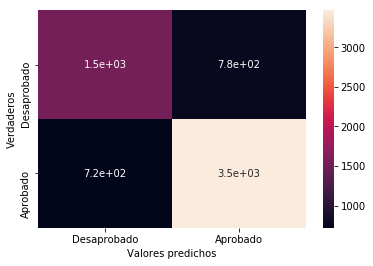

In [211]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels=["Desaprobado", "Aprobado"], yticklabels=["Desaprobado", "Aprobado"])
plt.ylabel('Verdaderos')
plt.xlabel('Valores predichos');

## Hacemos un GridSearch sobre RF

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [40]:
param_trees = {'n_estimators': [50, 100, 200], 
               'max_features': [1, 5, 8, 10, 21], 
               'max_depth': [5, 20, 50, 70, 100], 
               'min_samples_leaf':[1, 5, 8, 10, 50]}

In [43]:
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

In [44]:
grid_search_rf = GridSearchCV(rforestclf, param_grid=param_trees, cv=cv, verbose=1, n_jobs=-1)

In [45]:
grid_search_rf.fit(X_train, y_train, sample_weight=weight)

Fitting 3 folds for each of 375 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  5.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=41, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=-1,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
 

In [46]:
RF_GS=grid_search_rf.best_estimator_

In [48]:
grid_search_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [49]:
y_predRFGS = RF_GS.predict(X_test) #Está usando la media y el desvió estándar del train, y no del test, así no hay data leakage
confusion_matrix(y_test, y_predRFGS)

array([[ 245,  258],
       [  70, 1290]], dtype=int64)

In [54]:
print('Métricas de predicción para test RandomForest con GS')
print("Accuracy:",'{:.2%}'.format(accuracy_score(y_test, y_predRFGS)))
print("Recall:",'{:.2%}'.format(recall_score(y_test, y_predRFGS)))
print("Precisión:",'{:.2%}'.format(precision_score(y_test, y_predRFGS)))
print("F1Score:",'{:.2%}'.format(f1_score(y_test,y_predRFGS)))

Métricas de predicción para test RandomForest con GS
Accuracy: 82.39%
Recall: 48.71%
Precisión: 77.78%
F1Score: 59.90%


## XGBoost

Pendiente: hacer un Gridsearch para poder tener los hiperparámetros. Después de correr XGBoost podemos hacer un results comparison ´(importances = list(rf.feature_importances_))´ para ver el peso de cada una de las variables y cuando se rompe el modelo.

In [215]:
!pip install xgboost

In [216]:
import xgboost as xgb

In [217]:
X = pd.concat([X_numericas, dummies_resul], axis=1)

In [218]:
y=stu.score_range2 #obtenemos nuestro "y" del dataframe stu

In [219]:
X.shape

(98378, 149)

In [220]:
y.shape

(98378,)

In [226]:
weight.shape

(98378,)

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [222]:
#data_dmatrix=xgb.DMatrix(data=X, label=y) ##no toma string

In [227]:
print(X_train.shape)
print(weight.shape)

(68864, 149)
(98378,)


In [228]:
xgb_clf = xgb.XGBClassifier(alpha=10, n_estimators=10, max_depth=5, random_state=1, n_jobs=-1)
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=1, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [229]:
y_pred = xgb_clf.predict(X_test) #Está usando la media y el desvió estándar del train, y no del test, así no hay data leakage
confusion_matrix(y_test, y_pred)

array([[10638,  3344],
       [ 3136, 12396]], dtype=int64)

In [230]:
print('Métricas de predicción para test XGBoost')
print("Accuracy:",'{:.2%}'.format(accuracy_score(y_test, y_pred)))
print("Recall:",'{:.2%}'.format(recall_score(y_test, y_pred)))
print("Precisión:",'{:.2%}'.format(precision_score(y_test, y_pred)))
print("F1Score:",'{:.2%}'.format(f1_score(y_test,y_pred)))

Métricas de predicción para test XGBoost
Accuracy: 78.04%
Recall: 76.08%
Precisión: 77.23%
F1Score: 76.65%


### Grid Search

In [91]:
grid_search_xgb = GridSearchCV(xgb_clf, param_grid=param_trees, cv=cv, verbose=1, n_jobs=-1)

In [ ]:
grid_search_xgb.fit(X_train, y_train, sample_weight=weight)

Fitting 3 folds for each of 375 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 19.7min


In [ ]:
XGB_GS=grid_search_xgb.best_estimator_

In [ ]:
grid_search_xgb.best_estimator_

In [ ]:
y_predXGBGS = XGB_GS.predict(X_test) #Está usando la media y el desvió estándar del train, y no del test, así no hay data leakage
confusion_matrix(y_test, y_predXGBGS)

In [ ]:
print('Métricas de predicción para test RandomForest con GS')
print("Accuracy:",'{:.2%}'.format(accuracy_score(y_test, y_predXGBGS)))
print("Recall:",'{:.2%}'.format(recall_score(y_test, y_predXGBGS)))
print("Precisión:",'{:.2%}'.format(precision_score(y_test, y_predXGBGS)))
print("F1Score:",'{:.2%}'.format(f1_score(y_test,y_predXGBGS)))

In [ ]:
plt.bar(X_train.columns, grid_search_rf.best_estimator_.feature_importances_)
plt.xticks(rotation="vertical")

## Otras cosas...

In [7]:
X.describe().T #vemos cómo es X

,count,mean,std,min,25%,50%,75%,max
DISCLISCI,22114.0,0.377563,0.945654,-2.4162,-0.26830,0.4046,1.04380,1.8837
TEACHSUP,22089.0,0.474632,0.807812,-2.7195,-0.11640,0.4922,1.44750,1.4475
IBTEACH,22102.0,0.544360,0.904051,-3.3405,0.00760,0.5268,1.01015,3.1829
TDTEACH,22014.0,0.432593,1.001452,-2.4476,-0.14950,0.4505,1.09750,2.0781
ENVAWARE,22662.0,0.400594,1.256571,-3.3765,-0.38640,0.3113,1.08230,3.2932
ENVOPT,8700.0,0.842075,1.225005,-1.7932,0.09290,0.8249,1.57790,3.0127
JOYSCIE,22611.0,0.512675,0.999633,-2.1154,-0.13790,0.5094,1.12250,2.1635
INTBRSCI,8500.0,0.594906,0.740558,-2.4981,0.23350,0.5305,0.97135,2.6033
INSTSCIE,22531.0,0.598529,0.900164,-1.9301,0.01250,0.3708,1.35600,1.7359
SCIEEFF,22553.0,0.157437,1.169030,-3.7565,-0.54600,0.1281,0.74230,3.2775


In [104]:
X.dropna(axis=0, inplace=True) #sacamos filas que tienen NaN
X.shape

(6209, 102)

In [105]:
listado=X.index.tolist()

In [106]:
y=y[listado] #sacamos las mismas filas en y 

In [107]:
y.shape

(6209,)

In [12]:
print(y.value_counts(normalize=True))

2    0.733451
1    0.266549
Name: score_range2, dtype: float64


In [126]:
#X=X.drop(["OUTHOURS","hisei","MMINS", "LMINS","SMINS","TMINS", "unfairteacher", "PARED"], axis=1 ) 
#opción de sacar no normalizadas

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12)

## Standarización (opcionalmente usar _scaled o no)

In [169]:
# Utilizamos sklearn para estandarizar la matriz de features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train["OUTHOURS","hisei"]))
X_test_scaled = scaler.transform(X_test)

C:\Users\an\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\an\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\an\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """


## KNN

In [170]:
def kfold(i):
    kf = KFold(n_splits=5, shuffle=True, random_state=12)
    model = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    dict_row_score = {'score_medio':np.mean(cv_scores),\
                      'score_std':np.std(cv_scores),'n_neighbours':i}
    return dict_row_score

In [171]:
scores_para_df_standar = []
for x in range(1,20):
    scores_para_df_standar.append(kfold(x))

df_scores_standar = pd.DataFrame(scores_para_df_standar)
best_k = df_scores_standar.loc[df_scores_standar.score_medio ==\
                               df_scores_standar.score_medio.max(),'n_neighbours'].values
best_k = best_k[0]
best_k

In [173]:
#Usamos el mejor k para el modelo
modelfinal = KNeighborsClassifier(n_neighbors=best_k)
modelfinal.fit(X_train,y_train)
y_pred = modelfinal.predict(X_test) #Está usando la media y el desvió estándar del train, y no del test, así no hay data leakage
confusion_matrix(y_test, y_pred)

array([[210, 204],
       [173, 966]], dtype=int64)

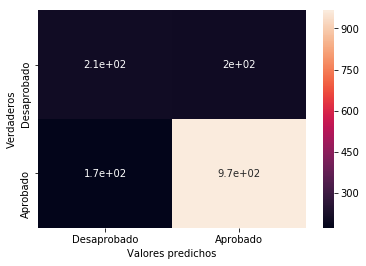

In [205]:
# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels=["Desaprobado", "Aprobado"], yticklabels=["Desaprobado", "Aprobado"])
plt.ylabel('Verdaderos')
plt.xlabel('Valores predichos');

## Métricas KNN

In [208]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

In [237]:
print('Métricas de predicción para test KNN')
print("Accuracy:",'{:.2%}'.format(metrics.accuracy_score(y_test, y_pred)))
print("Recall:",'{:.2%}'.format(metrics.recall_score(y_test, y_pred)))
print("Precisión:",'{:.2%}'.format(metrics.precision_score(y_test, y_pred)))
print("F1Score:",'{:.2%}'.format(f1_score(y_test,y_pred)))

Métricas de predicción para test KNN
Accuracy: 75.72%
Recall: 50.72%
Precisión: 54.83%
F1Score: 52.70%


## Regresión Logistíca

In [61]:
from sklearn import linear_model

In [185]:
lg = linear_model.LogisticRegression()
lg.fit(X_train, y_train)
y_pred_train = lg.predict(X_train)
y_predLR = lg.predict(X_test)

C:\Users\an\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


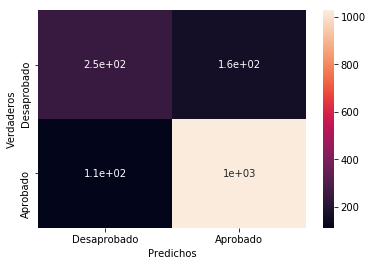

In [204]:
# Matriz de confusión:
confusion_matrix(y_test, y_predLR)
sns.heatmap(confusion_matrix(y_test, y_predLR), annot=True, xticklabels=["Desaprobado", "Aprobado"], yticklabels=["Desaprobado", "Aprobado"])
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

## Métricas regresión Logística

In [235]:
print('Métricas de predicción para test Regresión Logística')
print("Accuracy:",'{:.2%}'.format(metrics.accuracy_score(y_test, y_predLR)))
print("Recall:",'{:.2%}'.format(metrics.recall_score(y_test, y_predLR)))
print("Precisión:",'{:.2%}'.format(metrics.precision_score(y_test, y_predLR)))
print("F1Score:",'{:.2%}'.format(f1_score(y_test,y_predLR)))

Métricas de predicción para test Regresión Logística
Accuracy: 82.29%
Recall: 60.87%
Precisión: 69.04%
F1Score: 64.70%


In [244]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_predLR, pos_label=1)
auc(fpr, tpr)

0.24525709050654657

In [209]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_predLR.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ValueError: Can only tuple-index with a MultiIndex

In [245]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

NameError: name 'roc_auc' is not defined

<Figure size 432x288 with 0 Axes>

## NaiveBayes

In [68]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB


In [190]:
modelo_NB = GaussianNB()
modelo_NB.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [234]:
# Con los features de test transformados calculamos las labels predichas
y_predNB = modelo_NB.predict(X_test)
confusion_matrix(y_test, y_predNB)

array([[292, 122],
       [287, 852]], dtype=int64)

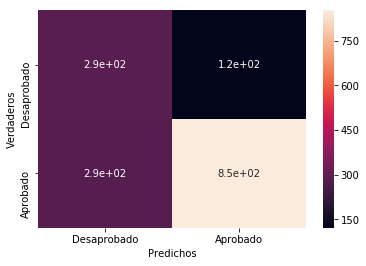

In [232]:
# Ahora graficamos la matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_predNB), annot=True, xticklabels=["Desaprobado", "Aprobado"], yticklabels=["Desaprobado", "Aprobado"])
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

## Métricas NB

In [228]:
print('Métricas de predicción para test GaussianNB')
print("Accuracy:",'{:.2%}'.format(metrics.accuracy_score(y_test, y_predNB)))
print("Recall:",'{:.2%}'.format(metrics.recall_score(y_test, y_predNB)))
print("Precisión:",'{:.2%}'.format(metrics.precision_score(y_test, y_predNB)))
print("F1Score:",'{:.2%}'.format(f1_score(y_test,y_predNB)))

Métricas de predicción para test GaussianNB
Accuracy: 73.66%
Recall: 70.53%
Precisión: 50.43%
F1Score: 58.81%


## TESTING PCA + GNB

In [142]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn import metrics

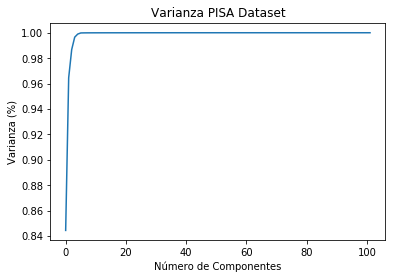

In [210]:
#Fiteamos PCA para nuestros datos
pca = PCA().fit(X_train)
#Gráfico de la varianza acumulada
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza (%)') #para cada componente
plt.title('Varianza PISA Dataset')
plt.show()

In [231]:
# Fit a nuestros datos y predicciones usando pipeline de GaussianNB y PCA.
unscaled_clf = make_pipeline(PCA(n_components=15), GaussianNB())
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)

# Métricas
print('Métricas de predicción para test con PCA y GaussianNB')
print("Accuracy:",'{:.2%}'.format(metrics.accuracy_score(y_test, pred_test)))
print("Recall:",'{:.2%}'.format(metrics.recall_score(y_test, pred_test)))
print("Precisión:",'{:.2%}'.format(metrics.precision_score(y_test, pred_test)))
print("F1Score:",'{:.2%}'.format(f1_score(y_test,pred_test)))

Métricas de predicción para test con PCA y GaussianNB
Accuracy: 80.55%
Recall: 50.72%
Precisión: 68.18%
F1Score: 58.17%
